In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import numpy as np
import sys, pickle, os, torch, cv2
# replace this path with path to GMIC
# sys.path.append("/home/said/Desktop/GMIC")

from src.data_loading import loading
from src.modeling import gmic as gmic



#############
import glob as glob
from torchvision import transforms
from torch.nn import functional as F
from torch import topk
#from model import Net

from torch import autograd
from torch import nn

### You need to obtain the cropped images (bash run.sh) before using this demo.

Step 1: prepare the input data

In [2]:
with open("sample_output/data.pkl", "rb") as f:
    exam_list = pickle.load(f)
datum = exam_list[1]
view = "R-CC"
short_file_path = datum[view][0]

Step 2: load the image

In [3]:
loaded_image = loading.load_image(
                    image_path=os.path.join("sample_output/cropped_images/", short_file_path + ".png"),
                    view=view, horizontal_flip=datum["horizontal_flip"])

In [4]:
loaded_image = loading.process_image(loaded_image, view, datum["best_center"][view][0])

Let's visualize a sample image

(2944, 1920)


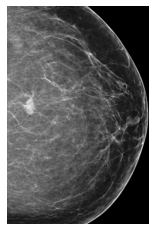

In [5]:
print(loaded_image.shape)
plt.imshow(loaded_image, cmap="Greys_r")
plt.axis("off")
plt.show()

Step 4: load the model

In [6]:
parameters = {
        "device_type":"cpu",
        "cam_size": (46, 30),
        "K": 6,
        "crop_shape": (256, 256),
        "percent_t":0.02
    }

In [23]:
model = gmic.GMIC(parameters)

In [24]:
model.load_state_dict(torch.load("models/sample_model_1.p", map_location="cpu"), strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=['shared_rep_filter.weight'])

In [51]:
model

GMIC(
  (ds_net): ResNetV2(
    (first_conv): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (first_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer_list): ModuleList(
      (0): Sequential(
        (0): BasicBlockV2(
          (relu): ReLU(inplace)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (downsample): Sequential(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): BasicBlockV2(
          (relu): ReLU(inplace)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [46]:
def gradcam(net, img_fpath):

    net.eval() #Esta

    def __extract(grad):
        global feature_grad
        feature_grad = grad

    img = PIL.Image.open(img_fpath).convert('RGB')
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = transforms(img)
    img = img.unsqueeze(0)

    # get features from the last convolutional layer
    x = net.conv1(img)
    x = net.bn1(x)
    x = net.relu(x)
    x = net.maxpool(x)
    x = net.layer1(x)
    x = net.layer2(x)
    x = net.layer3(x)
    x = net.layer4(x)
    features = x #Hasta aca tiene todo omargod

    # hook for the gradients
    def __extract_grad(grad):
        global feature_grad
        feature_grad = grad
    features.register_hook(__extract_grad)

    # get the output from the whole VGG architecture
    x = net.avgpool(x)
    x = x.view(x.size(0), -1)
    output = net.fc(x)
    pred = torch.argmax(output).item()
    print(pred)

    # get the gradient of the output
    output[:, pred].backward()

    # pool the gradients across the channels
    pooled_grad = torch.mean(feature_grad, dim=[0, 2, 3])

    # weight the channels with the corresponding gradients
    # (L_Grad-CAM = alpha * A)
    features = features.detach()
    for i in range(features.shape[1]):
        features[:, i, :, :] *= pooled_grad[i] 

    # average the channels and create an heatmap
    # ReLU(L_Grad-CAM)
    heatmap = torch.mean(features, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)

    # normalization for plotting
    heatmap = heatmap / torch.max(heatmap)
    heatmap = heatmap.numpy()

    # project heatmap onto the input image
    img = cv2.imread(img_fpath)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    plt.imshow(superimposed_img)
    plt.show()

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_convert_crop_position',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_retrieve_crop',
 '_slow_forward',
 '_state_dict_hooks',
 '_tracing_name',
 '_version',
 'add_module',
 'aggregation_function',
 'apply',
 'attention_module',
 'buffers',
 'cam_size',
 'children',
 'classifier_linear',
 'cpu',
 'cuda',
 'dn_resnet',
 'double',
 'ds_ne

In [ ]:
tensor_batch = torch.Tensor(np.expand_dims(np.expand_dims(loaded_image, 0), 0).copy()) #La imagen como tensor
output = model(tensor_batch) #Prediccion de la imagen
pred_numpy = output.data.cpu().numpy() #Prediccion de tensor a array
malignant_pred = pred_numpy[0, 1]

In [ ]:
print("malignant prediction = {}".format(malignant_pred))

Step 6: visualize the saliency map

In [ ]:
saliency_maps = model.saliency_map.data.cpu().numpy()
malignant_saliency_map = saliency_maps[0,1,:,:]
alphas = np.abs(np.linspace(0, 0.95, 259))
alpha_red = plt.cm.get_cmap('Reds')
plt.figure()
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(cv2.resize(malignant_saliency_map, (1920, 2944)), alpha=0.3, cmap=alpha_red, clim=[0.0, 1.0])
plt.axis("off")
plt.show()

In [ ]:
heatmap = malignant_saliency_map
heatmap1 = heatmap
plt.imshow(heatmap)

In [ ]:
plt.figure()
a = cv2.resize(heatmap, (1920, 2944))
heatmap = a
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(a, alpha=0.6)
plt.axis("off")
plt.show()

In [ ]:
plt.figure()
a = cv2.resize(heatmap1, (20, 30))
a = cv2.resize(a, (1920, 2944))
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(a, alpha=0.6)
plt.axis("off")
plt.show()

In [ ]:
m = cv2.resize(heatmap1, (2, 3))
plt.imshow(m)

In [ ]:
m

In [ ]:
np.max(m)

In [ ]:
plt.figure()
a = cv2.resize(heatmap, (2499, 3805))#(1920, 2944))
heatmap = a
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(a, alpha=0.6)
plt.axis("off")
plt.show()

In [ ]:
model